In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
tf.random.set_seed(1)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2023-04-13 10:43:00--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 142.250.128.101, 142.250.128.138, 142.250.128.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.128.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/deugrmguj4qnqhvv37ueotoo8jnv9opi/1681382550000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=055e01fb-7e96-4802-9264-c7228e316885 [following]
--2023-04-13 10:43:00--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/deugrmguj4qnqhvv37ueotoo8jnv9opi/1681382550000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=055e01fb-7e96-4802-9264-c7228e316885
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 172.217.212.132, 

In [ ]:
airline_passengers_data = pd.read_csv('/content/airline-passengers.csv')

In [ ]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Разобьем дату на столбцы, содержащие отдельно месяц и год.

In [ ]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [ ]:
def new_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['month'] = months

    return df

In [ ]:
airline_passengers_data = new_date(airline_passengers_data, 'Month')

In [ ]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,month
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [ ]:
train_size = 100

features = ['Passengers', 'year', 'month']

bias = 5

train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]


Создаем данные для обучения

In [ ]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [ ]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,month
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [ ]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [ ]:
start = x_len + future
end = start + train_size


X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future


X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

In [ ]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [ ]:
results = pd.DataFrame()
model = []
train_m = []
test_m = []

**SimpleRNN**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3, 32)             1120      
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-trai

In [ ]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 3s 30ms/step - loss: 56835.4180 - mae: 225.9509 - val_loss: 193952.9375 - val_mae: 433.1013
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 56551.3047 - mae: 225.3367 - val_loss: 192931.7812 - val_mae: 431.9662
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 56349.0312 - mae: 225.0544 - val_loss: 191566.6875 - val_mae: 430.4524
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 55904.8203 - mae: 224.3533 - val_loss: 188713.6094 - val_mae: 427.2689
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 54745.6719 - mae: 222.4128 - val_loss: 181782.0938 - val_mae: 419.3822
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 51672.4023 - mae: 216.9365 - val_loss: 165036.1250 - val_mae: 399.4848
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 44093.5547 - mae: 201.8603 - val_loss: 129019.1484 - val_mae: 3

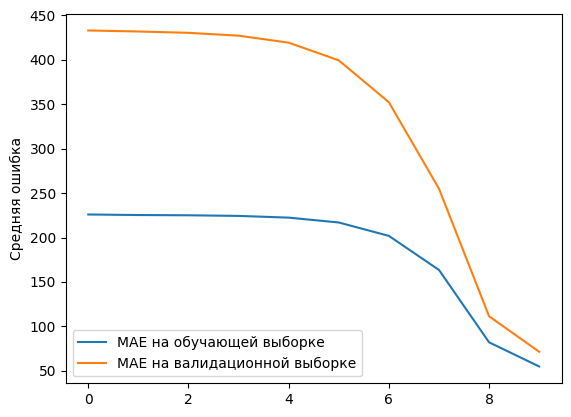

In [ ]:
plt.plot(history_1.history['mae'][:],
         label='MAE на обучающей выборке')
plt.plot(history_1.history['val_mae'][:],
         label='MAE на валидационной выборке')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [ ]:
num_iterations = 20

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 2251.4419 - mae: 38.3574 - val_loss: 15663.4668 - val_mae: 105.6419
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 1757.4054 - mae: 34.2924 - val_loss: 15361.1387 - val_mae: 105.3457
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 1573.6661 - mae: 31.8720 - val_loss: 13275.7510 - val_mae: 96.3026
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 1493.0522 - mae: 31.1755 - val_loss: 13314.3252 - val_mae: 96.5812
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 1361.6141 - mae: 29.4141 - val_loss: 12991.8447 - val_mae: 95.1224
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1300.3423 - mae: 28.7166 - val_loss: 12486.0000 - val_mae: 92.8229
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 1237.9249 - mae: 28.0307 - val_loss: 12294.4629 - val_mae: 92.0644
Epoch 8/10
13/13 [

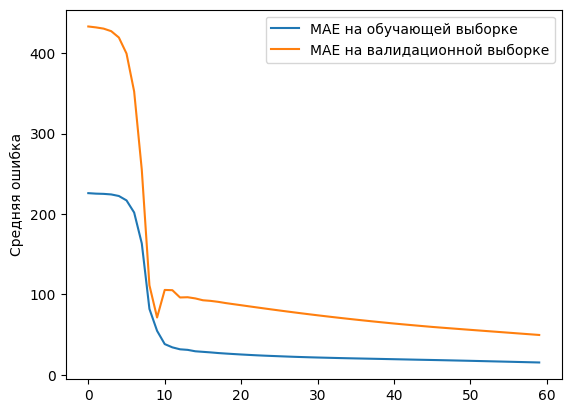

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 361.0981 - mae: 15.2601 - val_loss: 3953.9744 - val_mae: 48.9768
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 350.1877 - mae: 15.0273 - val_loss: 3848.3137 - val_mae: 48.2718
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 339.5863 - mae: 14.8057 - val_loss: 3744.7292 - val_mae: 47.5845
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 329.3192 - mae: 14.5869 - val_loss: 3643.2803 - val_mae: 46.9078
Epoch 5/10
13/13 [==============================] - 0s 17ms/step - loss: 319.4050 - mae: 14.3672 - val_loss: 3544.0374 - val_mae: 46.2339
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 309.8610 - mae: 14.1469 - val_loss: 3447.0439 - val_mae: 45.5633
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 300.6976 - mae: 13.9273 - val_loss: 3352.3660 - val_mae: 44.8965
Epoch 8/10
13/13 [================

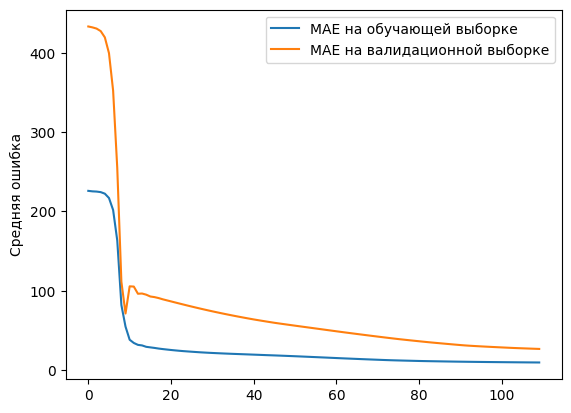

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 142.5301 - mae: 9.6491 - val_loss: 1268.3154 - val_mae: 26.5994
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 141.5742 - mae: 9.6132 - val_loss: 1254.0701 - val_mae: 26.4680
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 140.6464 - mae: 9.5776 - val_loss: 1240.5635 - val_mae: 26.3533
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 139.7431 - mae: 9.5431 - val_loss: 1227.7565 - val_mae: 26.2394
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 138.8620 - mae: 9.5095 - val_loss: 1215.6089 - val_mae: 26.1262
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 138.0000 - mae: 9.4759 - val_loss: 1204.0933 - val_mae: 26.0138
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 137.1548 - mae: 9.4424 - val_loss: 1193.1682 - val_mae: 25.9019
Epoch 8/10
13/13 [=======================

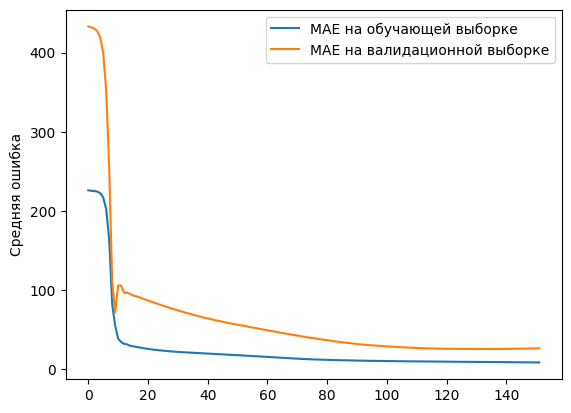

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 110.9430 - mae: 8.2201 - val_loss: 1037.2013 - val_mae: 25.9539
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 116.8321 - mae: 8.6399 - val_loss: 1077.8110 - val_mae: 26.8458
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 121.7654 - mae: 8.8222 - val_loss: 1016.0341 - val_mae: 25.4516
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 165.2775 - mae: 10.4394 - val_loss: 1159.4667 - val_mae: 28.6708
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 261.2556 - mae: 13.8000 - val_loss: 1001.8143 - val_mae: 24.3887
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 559.4205 - mae: 17.5086 - val_loss: 1468.0897 - val_mae: 33.5903
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 1151.1504 - mae: 26.5356 - val_loss: 1319.0050 - val_mae: 26.8200
Epoch 8/10
13/13 [==================

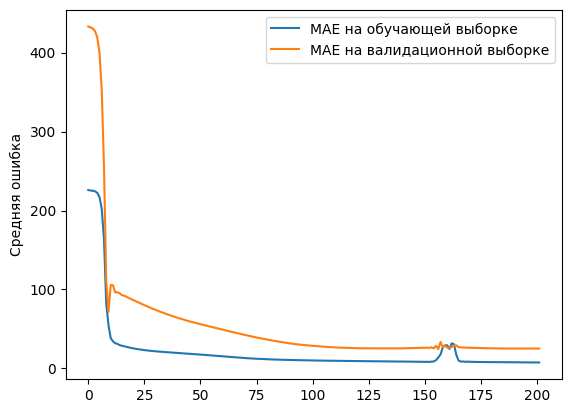

In [ ]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1,
            label='MAE на обучающей выборке')
    plt.plot(hist_val_1,
            label='MAE на валидационной выборке')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 5ms/step


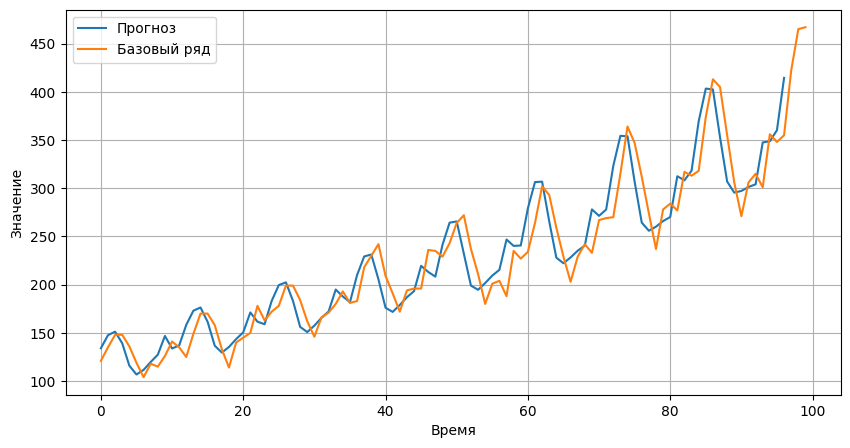

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

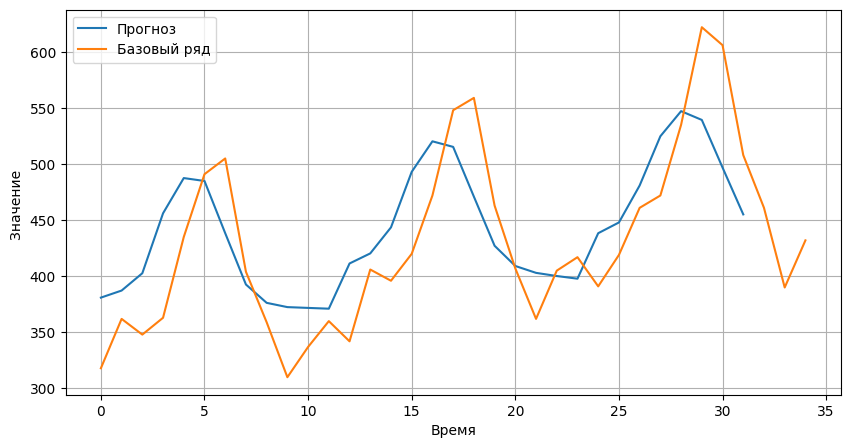

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [ ]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 7ms/step - loss: 969.5558 - mae: 25.1873
train_loss: 86.4666976928711, train_m: 7.15401029586792
test_loss: 969.5557861328125, test_m: 25.187267303466797


**LSTM**

In [ ]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 32)             4480      
                                                                 
 lstm_3 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_8 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 5s 70ms/step - loss: 56664.9219 - mae: 225.6467 - val_loss: 193125.2969 - val_mae: 432.1388
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56433.8203 - mae: 225.1531 - val_loss: 192433.7812 - val_mae: 431.3459
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 55776.4180 - mae: 223.8171 - val_loss: 190060.8281 - val_mae: 428.6164
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 53506.4180 - mae: 219.1752 - val_loss: 181442.2500 - val_mae: 418.5708
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 46140.5703 - mae: 203.4588 - val_loss: 152712.6562 - val_mae: 383.2306
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 26234.2363 - mae: 153.0354 - val_loss: 77501.2969 - val_mae: 269.5848
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 1677.9728 - mae: 32.0325 - val_loss: 7011.7295 - val_mae: 63.887

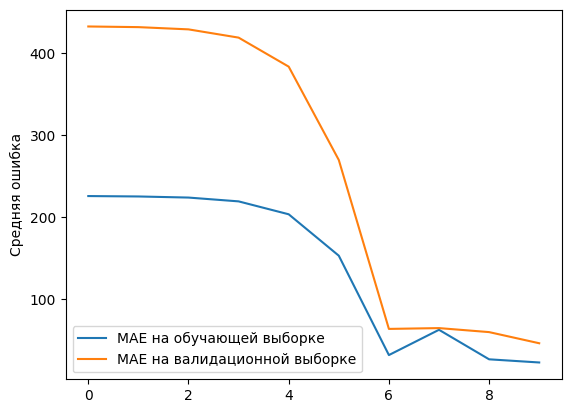

In [ ]:
plt.plot(history_2.history['mae'][:],
         label='MAE на обучающей выборке')
plt.plot(history_2.history['val_mae'][:],
         label='MAE на валидационной выборке')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [ ]:
num_iterations = 20

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 715.3258 - mae: 20.9036 - val_loss: 4790.8447 - val_mae: 50.4292
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 698.8581 - mae: 20.5408 - val_loss: 4787.0425 - val_mae: 50.3928
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 693.6640 - mae: 20.6010 - val_loss: 4552.8091 - val_mae: 49.2763
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 683.7742 - mae: 20.3817 - val_loss: 4587.5542 - val_mae: 49.4233
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 681.3314 - mae: 20.3648 - val_loss: 4451.3452 - val_mae: 48.7378
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 677.7988 - mae: 20.3240 - val_loss: 4421.3193 - val_mae: 48.5728
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 674.2937 - mae: 20.2980 - val_loss: 4363.0005 - val_mae: 48.3057
Epoch 8/10
13/13 [================

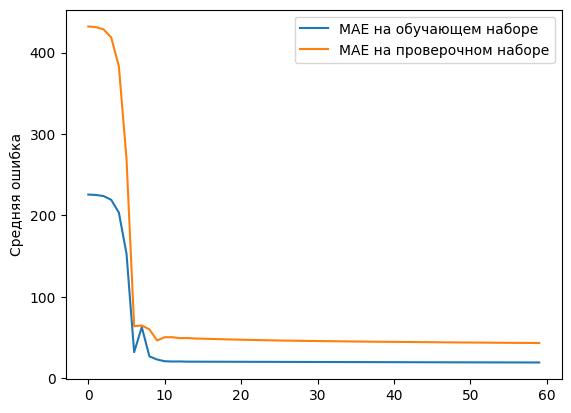

Epoch 1/10
13/13 [==============================] - 0s 16ms/step - loss: 602.6295 - mae: 19.3460 - val_loss: 3337.8147 - val_mae: 43.2520
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 601.3829 - mae: 19.3312 - val_loss: 3323.0154 - val_mae: 43.1964
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 600.1258 - mae: 19.3158 - val_loss: 3308.1841 - val_mae: 43.1392
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 598.8565 - mae: 19.2998 - val_loss: 3293.3237 - val_mae: 43.0804
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 597.5730 - mae: 19.2844 - val_loss: 3278.4211 - val_mae: 43.0199
Epoch 6/10
13/13 [==============================] - 0s 23ms/step - loss: 596.2736 - mae: 19.2689 - val_loss: 3263.4724 - val_mae: 42.9576
Epoch 7/10
13/13 [==============================] - 0s 22ms/step - loss: 594.9562 - mae: 19.2527 - val_loss: 3248.4648 - val_mae: 42.8934
Epoch 8/10
13/13 [================

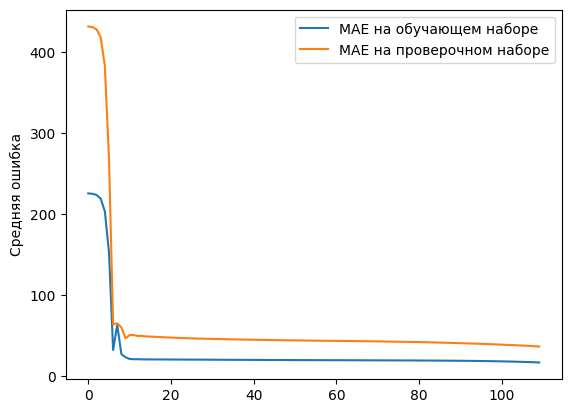

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 421.9106 - mae: 16.3172 - val_loss: 2204.2012 - val_mae: 35.9115
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 410.3299 - mae: 16.0983 - val_loss: 2154.1338 - val_mae: 35.6233
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 398.1399 - mae: 15.8837 - val_loss: 2101.8408 - val_mae: 35.3468
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 385.3690 - mae: 15.6541 - val_loss: 2047.3687 - val_mae: 35.0624
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 372.0630 - mae: 15.4034 - val_loss: 1990.8193 - val_mae: 34.7798
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 358.2851 - mae: 15.1478 - val_loss: 1932.3469 - val_mae: 34.4548
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 344.1183 - mae: 14.8972 - val_loss: 1872.1669 - val_mae: 34.1595
Epoch 8/10
13/13 [================

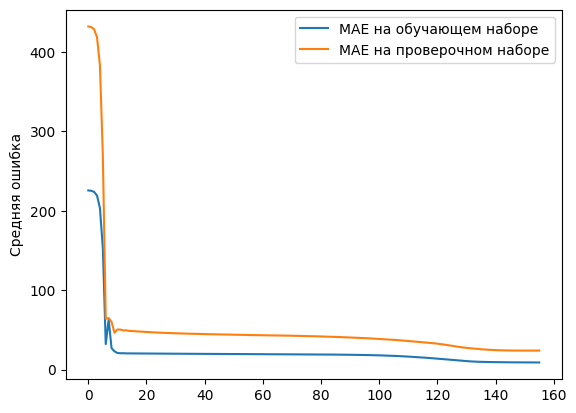

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 135.1628 - mae: 8.9104 - val_loss: 823.9542 - val_mae: 23.9304
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 134.7263 - mae: 8.8979 - val_loss: 823.5583 - val_mae: 23.9416
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 134.3069 - mae: 8.8870 - val_loss: 823.3766 - val_mae: 23.9533
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 133.9033 - mae: 8.8774 - val_loss: 823.3931 - val_mae: 23.9656
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 133.5152 - mae: 8.8678 - val_loss: 823.5836 - val_mae: 23.9781
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 133.1411 - mae: 8.8584 - val_loss: 823.9471 - val_mae: 23.9918
Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 132.7805 - mae: 8.8491 - val_loss: 824.4742 - val_mae: 24.0236
Epoch 2/10
13/13 [==============================

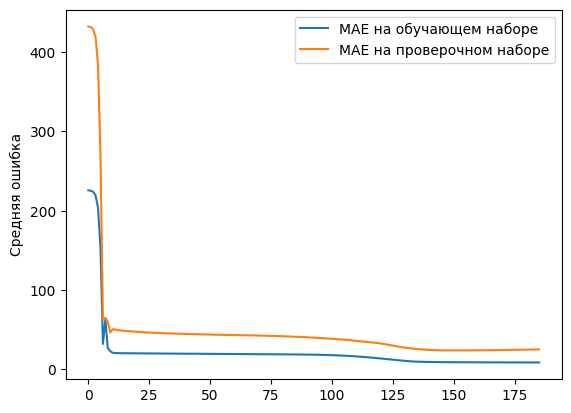

In [ ]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2,
            label='MAE на обучающей выборке')
    plt.plot(hist_val_2,
            label='MAE на валидационной выборке')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [ ]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 3ms/step


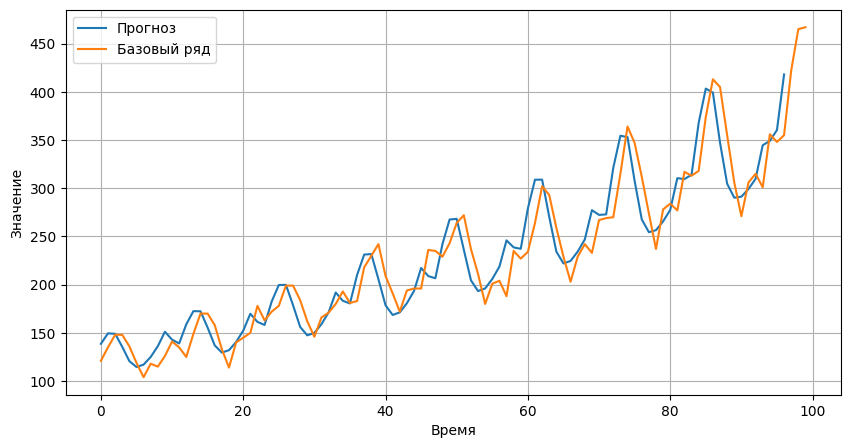

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size],
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

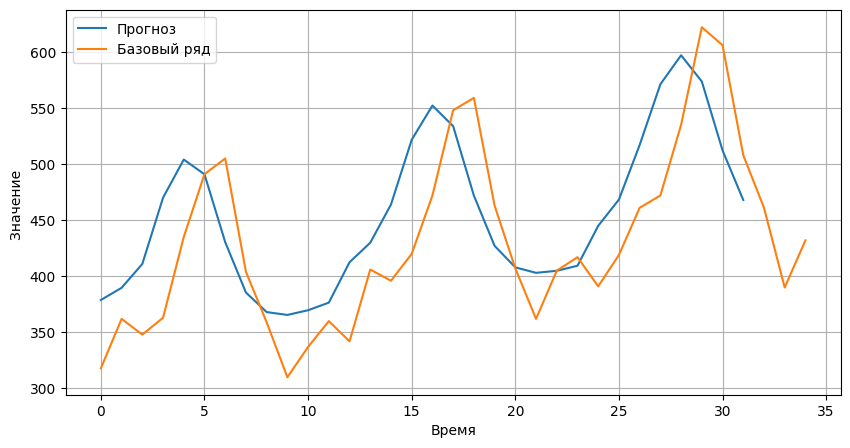

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step],
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [ ]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 5ms/step - loss: 865.2494 - mae: 25.1990
train_loss: 104.78641510009766, train_m: 7.952630996704102
test_loss: 865.2493896484375, test_m: 25.199047088623047


Общий результат

In [ ]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [ ]:
results

,model,train_m,test_m
0,SimpleRNN,7.15,25.19
1,LSTM,7.95,25.20


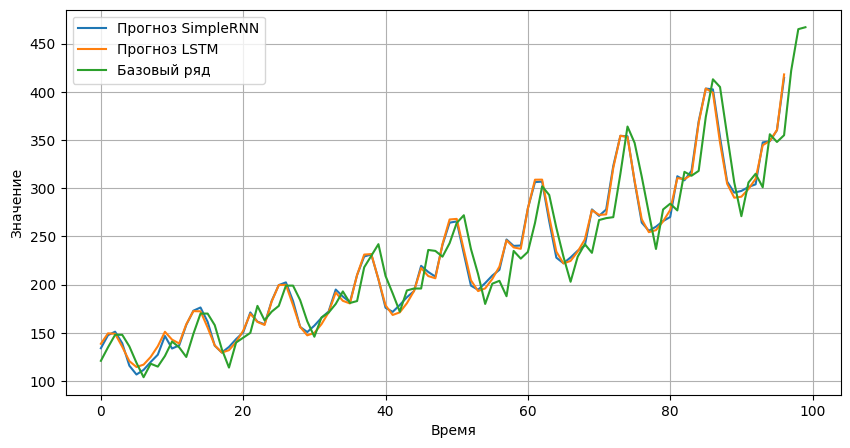

In [ ]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size],
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size],
         label='Прогноз LSTM')
plt.plot(y_train.flatten()[start: train_size],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

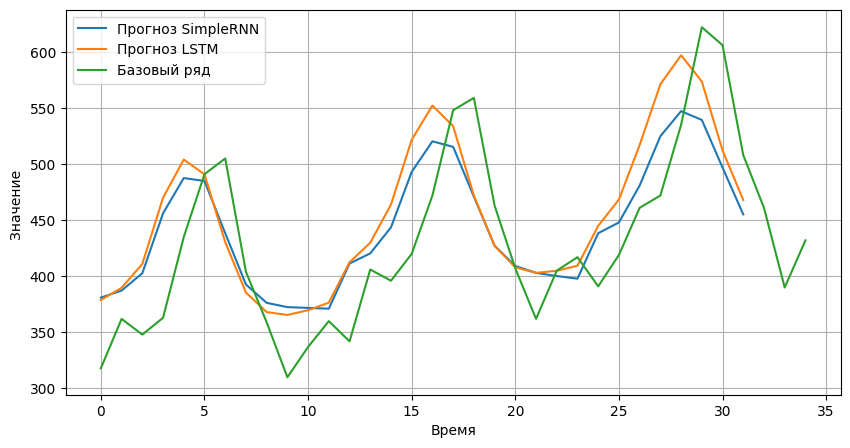

In [ ]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step],
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step],
         label='Прогноз LSTM')
plt.plot(y_val.flatten()[start: start+step],
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Выводы:
* чем больше итераций - тем выше качество
